In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import time

from sklearn import preprocessing

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print('Using device:', device)

Using device: cuda


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성
### 데이터 필터링 및 저장

In [3]:
combined_df = pd.read_csv(f'./final_dataset/combined_pps_data_fin.csv')
combined_df.head()

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.523810,27.619048,41.428571,2.380952,0.476190,0.476190,0.476190,0.714286,0.714286,0.714286,100.000000,54.285714,38.095238,19.047619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,C1,CA019C,CA013A,CC022A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
3,0504PA001_T002,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
tmp_df = combined_df.copy()
tmp_df = tmp_df.fillna(np.nan)

# 원재료 코드 리스트 생성
JRCODE_ls = []
jrcode_col_ls = [col for col in tmp_df.columns if 'JRCODE' in col]
for jrcode_col in jrcode_col_ls:
    JRCODE_ls += tmp_df[jrcode_col].unique().tolist()
    JRCODE_ls = list(set(JRCODE_ls))
    JRCODE_ls = [x for x in JRCODE_ls if str(x) != 'nan']

# 이상 원재료코드 리스트 생성
rm_jrcode_ls = [jr for jr in JRCODE_ls if 'C1' in jr]

for rm_jr in rm_jrcode_ls:
    JRCODE_ls.remove(rm_jr)

# 원재료 코드 테이블 생성
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index
JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 공정 타입 테이블 생성 (1-6)
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1 # (1-6)
PUTGB_df.columns = ['PUTGB_ID','PUTGB']

display(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

# 원재료 코드 dictionary 생성
JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

# 공정 타입 dictionary 생성
PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 마지막으로 추가
JRCODE_dict['0'] = len(JRCODE_dict)
PUTGB_dict['0'] = len(PUTGB_dict)

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}')

'전체 원재료코드 수 : 833, 공정종류 수 : 6'

'NAN포함!! JRCODE 딕셔너리 길이: 834, PUTGB 딕셔너리 길이: 7'

### 이상치 원재료 포함 데이터 제거 및 원재료 코드 정수화, 변수 타입별 데이터 정규화

In [5]:
# 이상한 원재료를 갖는 데이터 제거
filtered_idx_ls = []
for rm_jrcode in rm_jrcode_ls:
    for col in jrcode_col_ls:
        tmp_tmp_df = tmp_df[~(tmp_df[col].isna())]
        filtered_idx_ls += tmp_tmp_df[(tmp_tmp_df[col].str.contains(rm_jrcode))].index.tolist()

        filtered_idx_ls = list(set(filtered_idx_ls))

tmp_df = tmp_df.iloc[[idx for idx in tmp_df.index if idx not in filtered_idx_ls]].reset_index(drop=True)
tmp_df = tmp_df.fillna(0)

# 원재료 코드 정수로 변환
data_df = tmp_df.copy()
for i in range(1, 26):
    data_df['JRCODE'+str(i)] = data_df['JRCODE'+str(i)].apply(lambda x: int(JRCODE_dict[str(x)]))
    data_df['PHR'+str(i)].fillna(0, inplace=True)

data_df

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,394,382,405,64,61,78,162,147,144,132,644,729,783,786,833,833,833,833,833,833,833,833,833,833,833,9.523810,27.619048,41.428571,2.380952,0.476190,0.476190,0.476190,0.714286,0.714286,0.714286,100.000000,54.285714,38.095238,19.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600,273,314,132,731,753,757,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T002,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600,273,314,132,731,753,757,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833,100.000000,10.000000,1.000000,2.

In [6]:
# MIN-MAX(0-1) 스케일러 생성 및 데이터 변환

# 입력변수 종류별 스케일러 저장
scaler_data_df = data_df.copy()
mColNmLs = ['RPM', 'TEMP', 'TIME', 'JUK', 'JRCODE', 'PHR', 'PUTGB']
scalerDic = {}
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    data = np.array(scaler_data_df[cols].values.tolist()).flatten().reshape(-1,1)
    # scalerDic[mCol] = preprocessing.StandardScaler().fit(data)
    scalerDic[mCol] = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(data)
    print(f'cols: {mCol}\tdata# : {len(data)}\tcol# : {len(cols)}\tMIN: {min(data)}\tMAX: {max(data)}')

# 출력변수별 스케일러 저장
trgColNmLs = ['HS_TEMP','HS_TIME','SG_TEMP','SG_TIME','TS_TEMP','TS_TIME','EB_TEMP','EB_TIME','HS_VAL','SG_VAL','TS_VAL','EB_VAL']
for trgCol in trgColNmLs:
    data = np.array(scaler_data_df[trgCol].values.tolist()).flatten().reshape(-1,1)
    # scalerDic[trgCol] = preprocessing.StandardScaler().fit(data)
    scalerDic[trgCol] = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(data)
    print(f'cols: {trgCol}\tdata# : {len(data)}\tcol# : {1}\tMIN: {min(data)}\tMAX: {max(data)}')

# 입력변수 종류별 스케일링
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    for col in cols:
        scaler_data_df[col] = scalerDic[mCol].transform(np.array(scaler_data_df[col]).reshape(-1, 1))

# 출력변수별 스케일링
for trgCol in trgColNmLs:
    scaler_data_df[trgCol] = scalerDic[trgCol].transform(np.array(scaler_data_df[trgCol]).reshape(-1, 1))

scaler_data_df

cols: RPM	data# : 700557	col# : 23	MIN: [0.]	MAX: [3882.]
cols: TEMP	data# : 700557	col# : 23	MIN: [0.]	MAX: [6551.1]
cols: TIME	data# : 700557	col# : 23	MIN: [0.]	MAX: [999.9]
cols: JUK	data# : 700557	col# : 23	MIN: [0.]	MAX: [6856.]
cols: JRCODE	data# : 761475	col# : 25	MIN: [0]	MAX: [833]
cols: PHR	data# : 761475	col# : 25	MIN: [0.]	MAX: [100.]
cols: PUTGB	data# : 761475	col# : 25	MIN: [0.]	MAX: [6.]
cols: HS_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: HS_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: SG_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: SG_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: TS_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: TS_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: EB_TEMP	data# : 30459	col# : 1	MIN: [0.]	MAX: [195.]
cols: EB_TIME	data# : 30459	col# : 1	MIN: [0.]	MAX: [30.]
cols: HS_VAL	data# : 30459	col# : 1	MIN: [23.]	MAX: [98.]
cols: SG_VAL	data# : 30459	col# : 1	MIN: [0.096]	MAX: [74.]
cols: T

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.054022,-0.082833,-0.027611,-0.846339,-0.853541,-0.812725,-0.611044,-0.647059,-0.654262,-0.683073,0.546218,0.750300,0.879952,0.887155,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-0.809524,-0.447619,-0.171429,-0.952381,-0.990476,-0.990476,-0.990476,-0.985714,-0.985714,-0.985714,1.000000,0.085714,-0.238095,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.743590,-0.333333,0.743590,-0.333333,0.743590,-0.333333,0.743590,-0.333333,0.360000,-0.972830,-0.786172,-0.937805
1,0504PA001_T001,LAB,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.440576,-0.344538,-0.246098,-0.683073,0.755102,0.807923,0.817527,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000

In [8]:
class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DenseBlock, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
        self.relu = nn.ReLU() # activation function

    def forward(self, x):
        return self.relu(self.dense(x))
     
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear1 = DenseBlock(input_size, 256)
        self.linear2 = DenseBlock(256, 64)
        self.linear3 = DenseBlock(64, 16)
        self.linear4 = nn.Linear(16, 1)
        self.dout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dout(self.linear1(x))
        x = self.dout(self.linear2(x))
        x = self.dout(self.linear3(x))
        x = self.linear4(x)
        return self.sigmoid(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, noise_size, output_size):
        super(Generator, self).__init__()

        self.linear1 = DenseBlock(noise_size, 128)
        self.linear2 = DenseBlock(128, 32)
        self.linear3 = DenseBlock(32, 128)
        self.linear4 = nn.Linear(128, output_size)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return self.tanh(x)

In [93]:
# # Discriminator 모델 정의
# class Discriminator(nn.Module):
#     def __init__(self, input_size):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 256),            
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(64, 16),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
    
#     def forward(self, x):
#         return self.model(x)

# # Generator 모델 정의
# class Generator(nn.Module):
#     def __init__(self, noise_size, output_size):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(noise_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Linear(64, 256),
#             nn.ReLU(),
#             # nn.BatchNorm1d(64),
#             nn.Linear(256, output_size),
#             nn.Tanh(),
#         )
    
#     def forward(self, x):
#         return self.model(x)   

In [10]:
batch_size = 64
lr = 0.0005

num_epochs = 150
show_step = 10
latent_size_ = 100

tmp_data_df = scaler_data_df.copy()

criterion = nn.BCELoss()

# 대상
trg_yCols = ['HS_VAL','SG_VAL','TS_VAL','EB_VAL']

# 필요없는 변수 제거
tmp_data_df = tmp_data_df.drop(['ID','TYPE'] + trg_yCols, axis=1)
# batch_size 로 나눠지도록 나머지 버림
tmp_data_df = tmp_data_df.iloc[:-(len(tmp_data_df) % batch_size)]

# DataFrame을 PyTorch Tensor로 변환
data = torch.tensor(tmp_data_df.values, dtype=torch.float32)

# DataLoader 설정
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 옵티마이저, 손실 함수 설정
input_size = len(tmp_data_df.columns)  # 입력 feature의 개수
output_size = input_size               # 출력 feature의 개수 (입력과 동일하게)
latent_size = latent_size_             # 잠재 공간의 크기

discriminator = Discriminator(input_size)
generator = Generator(latent_size, output_size)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

# 학습 시작
stTime = time.time()

gen_loss_trace = []
dis_real_loss_trace = []
dis_fake_loss_trace = []

dis_real_acc_trace = []
dis_fake_acc_trace = []

for epoch in range(num_epochs):    
    gen_loss = 0
    dis_loss = 0

    dis_real_loss = 0
    dis_fake_loss = 0

    dis_real_acc = 0
    dis_fake_acc = 0

    cnt = 0
    for n, (real_data,) in enumerate(dataloader):
        # batch_size = real_data.size(0)

        # Data for training
        real_data_labels = torch.ones((batch_size, 1))
        fake_data_labels = torch.zeros((batch_size, 1))

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # Initialize grad
        g_optimizer.zero_grad()

        # make fake data with generator & noise vector 'z'
        z = torch.randn((batch_size, latent_size))

        """
        FOR CONDITIONAL GAN
        """
        fake_data = generator(z)

        # Compare result of discriminator with fake data & real labels
        # If generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_data), real_data_labels)

        # Train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        gen_loss += g_loss.item()/batch_size

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # Initialize grad
        d_optimizer.zero_grad()
        
        # make fake data with generator & noise vector 'z'
        z = torch.randn((batch_size, latent_size))
        fake_data = generator(z)

        """
        FOR CONDITIONAL DIS
        """
        output_real = discriminator(real_data)
        output_fake = discriminator(fake_data)

        # Calculate fake & real loss with generated data above & real data
        real_loss = criterion(output_real, real_data_labels)
        fake_loss = criterion(output_fake, fake_data_labels)
        d_loss = (fake_loss + real_loss) / 2

        # Train discriminator with backpropagation
        # In this part, we don't train generator
        d_loss.backward()
        d_optimizer.step()

        d_real_acc = (output_real.round() == real_data_labels).float().sum()
        d_fake_acc = (output_fake.round() == fake_data_labels).float().sum()

        dis_real_acc += d_real_acc.item()/batch_size
        dis_fake_acc += d_fake_acc.item()/batch_size

        dis_real_loss += real_loss.item()/batch_size
        dis_fake_loss += fake_loss.item()/batch_size
        dis_loss += d_loss.item()/batch_size     

        cnt+=1
    dis_real_acc = dis_real_acc/cnt
    dis_fake_acc = dis_fake_acc/cnt

    # Show loss
    if epoch % show_step == 0:
        print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, Acc real D.: {dis_real_acc:.5f}, Acc gen D.: {dis_fake_acc:.5f}, time: {(time.time() - stTime):.3f}s")
        stTime = time.time()

    gen_loss_trace.append(gen_loss)

    dis_real_loss_trace.append(dis_real_loss)
    dis_fake_loss_trace.append(dis_fake_loss)

    dis_real_acc_trace.append(dis_real_acc)
    dis_fake_acc_trace.append(dis_fake_acc)

Epoch:   0 Loss D.: 2.47829, Loss G.: 13.21489, Acc real D.: 0.89993, Acc gen D.: 0.83497, time: 3.361s
Epoch:  10 Loss D.: 4.18670, Loss G.: 8.11762, Acc real D.: 0.55668, Acc gen D.: 0.83266, time: 43.719s
Epoch:  20 Loss D.: 4.70998, Loss G.: 5.94121, Acc real D.: 0.50796, Acc gen D.: 0.73780, time: 68.311s
Epoch:  30 Loss D.: 5.06997, Loss G.: 5.40407, Acc real D.: 0.43553, Acc gen D.: 0.63615, time: 64.639s
Epoch:  40 Loss D.: 5.14437, Loss G.: 5.14602, Acc real D.: 0.00122, Acc gen D.: 0.99901, time: 63.735s
Epoch:  50 Loss D.: 4.75921, Loss G.: 5.83816, Acc real D.: 0.50961, Acc gen D.: 0.71757, time: 63.422s
Epoch:  60 Loss D.: 4.68650, Loss G.: 6.30171, Acc real D.: 0.49490, Acc gen D.: 0.76878, time: 66.346s
Epoch:  70 Loss D.: 4.59600, Loss G.: 6.88289, Acc real D.: 0.55063, Acc gen D.: 0.75786, time: 67.590s
Epoch:  80 Loss D.: 4.52618, Loss G.: 6.67661, Acc real D.: 0.55770, Acc gen D.: 0.75572, time: 63.102s
Epoch:  90 Loss D.: 4.12015, Loss G.: 7.88037, Acc real D.: 0.60

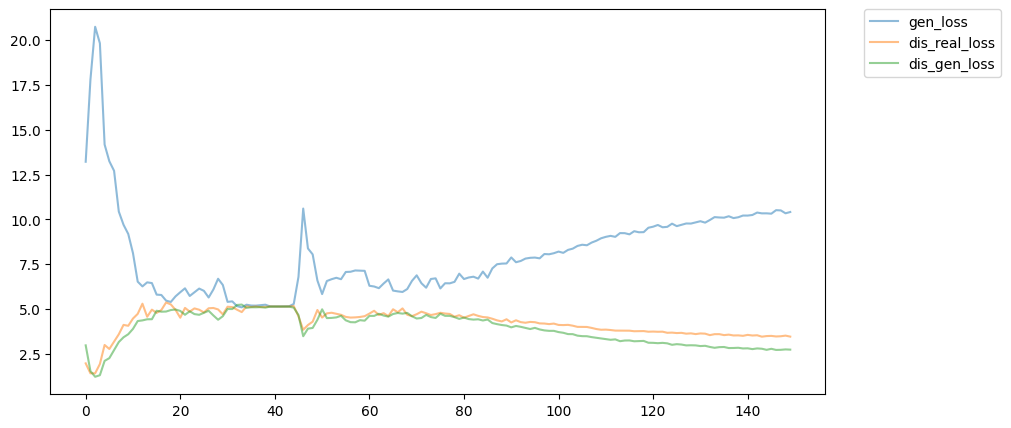

In [11]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(dis_real_loss_trace[sIdx:], label='dis_real_loss', alpha=0.5)
plt.plot(dis_fake_loss_trace[sIdx:], label='dis_gen_loss', alpha=0.5)
# plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

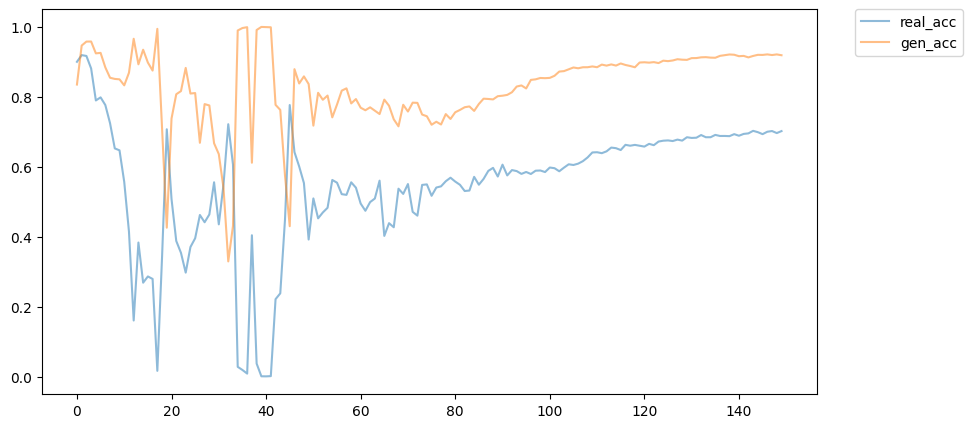

In [14]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(10, 5))
plt.plot(dis_real_acc_trace[sIdx:], label='real_acc', alpha=0.5)
plt.plot(dis_fake_acc_trace[sIdx:], label='gen_acc', alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [45]:
# 임의의 데이터 생성

n_samples = len(tmp_data_df)
gen_samples = generator(torch.randn(n_samples, latent_size))
gen_df = pd.DataFrame(gen_samples.detach(), columns=tmp_data_df.columns)
# display('gen:',gen_df.describe(),'ori:',tmp_data_df[tmp_data_df[yCol+'_G']==trg_label].describe())
display('ori:',tmp_data_df.iloc[:,:].describe(),'gen:',gen_df.iloc[:,:].describe())

'ori:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.0,30400.0,30400.0,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000
mean,-0.932558,-0.930677,-0.931067,-0.921342,-0.923781,-0.923138,-0.942184,-0.943328,-0.948043,-0.894830,-0.855523,-0.792910,-0.721184,-0.650114,-0.606245,-0.673553,-0.692064,-0.779352,-0.838397,-0.944241,-0.988168,-0.991201,-0.999770,-0.975067,-0.981346,-0.981888,-0.979932,-0.975917,-0.972470,-0.968366,-0.965323,-0.964119,-0.964995,-0.970019,-0.977588,-0.983512,-0.987034,-0.988265,-0.989438,-0.990347,-0.992993,-0.995553,-0.997464,-0.998711,-0.999491,-0.999865,-0.872317,-0.964994,-0.948945,-0.948472,-0.947058,-0.958607,-0.952444,-0.955465,-0.961404,-0.9

'gen:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000
mean,-0.950922,-0.887367,-0.954922,-0.960413,-0.978965,-0.918624,-0.953632,-0.980572,-0.980428,-0.944678,-0.923742,-0.904373,-0.917328,-0.858494,-0.888966,-0.907501,-0.922282,-0.937839,-0.960370,-0.970826,-0.996010,-0.987386,-0.999415,-0.995931,-0.996150,-0.989470,-0.972786,-0.991217,-0.979654,-0.936506,-0.983379,-0.981445,-0.978423,-0.982415,-0.991873,-0.998606,-0.996399,-0.993029,-0.910861,-0.995560,-0.996350,-0.964885,-0.975932,-0.959702,-0.993885,-0.907784,-0.829195,-0.976199,-0.944345,-0.980168,-0.958197,-0.985645,-0.969329,-0.867816

In [46]:
### 역스케일링과 실수값 반올림

tmp_gen_df = gen_df.copy()

# 입력변수 종류별 스케일링
for mCol in mColNmLs:
    cols = [col for col in scaler_data_df.columns if (mCol in col) & ('_' not in col)]
    for col in cols:
        tmp_gen_df[col] = scalerDic[mCol].inverse_transform(np.array(tmp_gen_df[col]).reshape(-1, 1))

# 출력변수별 스케일링
for trgCol in [col for col in trgColNmLs if col not in trg_yCols] :
    tmp_gen_df[trgCol] = scalerDic[trgCol].inverse_transform(np.array(tmp_gen_df[trgCol]).reshape(-1, 1))

tmp_gen_df = tmp_gen_df.round()

In [47]:
### 원재료코드와 공정순거에 대한 후처리

jr_colNm_ls = [col for col in tmp_gen_df.columns.tolist() if 'JRCODE' in col]
pt_colNm_ls = [col for col in tmp_gen_df.columns.tolist() if 'PUTGB' in col]

JRCODE_ls = list(JRCODE_dict.keys())

for col in jr_colNm_ls:
    idxs = tmp_gen_df[col].tolist()
    tmp_gen_df[col] = [JRCODE_ls[int(idx)] for idx in idxs]

tmp_gen_df[jr_colNm_ls] = tmp_gen_df[jr_colNm_ls].apply(lambda row: [ele for ele in row.values.tolist() if ele != '0'], axis=1).apply(lambda x: x + [np.nan] * (25 - len(x)) if isinstance(x, list) else x).tolist()
tmp_gen_df[pt_colNm_ls] = tmp_gen_df[pt_colNm_ls].apply(lambda row: [ele for ele in row.values.tolist() if ele != 0], axis=1).apply(lambda x: x + [np.nan] * (25 - len(x)) if isinstance(x, list) else x).tolist()
tmp_gen_df

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,EU001,EE006A,OP008,CD010,CA032A,EE001A,CA027A,CH009A,CB019A,CT001B,CV003B,PL002A,PZ008A,PE001A,PZ014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,38.0,86.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,86.0,22.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,9.0,175.0,7.0,167.0,8.0,134.0,8.0
1,0.0,20.0,7.0,0.0,1.0,9.0,2.0,355.0,1.0,76.0,0.0,0.0,1.0,250.0,0.0,0.0,0.0,31.0,56.0,0.0,481.0,1.0,0.0,5.0,0.0,1.0,1.0,8.0,1.0,91.0,52.0,2.0,0.0,2.0,3.0,0.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,22.0,12.0,0.0,3.0,14.0,4.0,38.0,0.0,0.0,1.0,8.0,1.0,0.0,33.0,2.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,8.0,52.0,92.0,2.0,432.0,4.0,0.0,0.0,1.0,5580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EN002,EE001,CA004A,CA001B,CF003,CA003,FF036A,PC001A,OZ008A,PL001,PZ014,PZ014,PZ011A,PZ011A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,75.0,4.0,0.0,0.0,0.0,97.0,96.0,76.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,10.0,129.0,7.0,127.0,8.0,151.0,8.0
2,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1085.0,0.0,0.0,59.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,EE016A,CV014A,CA011D,CB002A,CA010,EY004,CC004C,PL003A,NN330F,PZ008A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,16.0,0.0,0.0,0.0,29.0,3.0,99.0,37.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,10.0,185.0,8.0,167.0,8.0,146.0,8.0
3,46.0,1576.0,29.0,152.0,18.0,44.0,101.0,215.0,26.0,10.0,310.0,568.0,626.0,1384.0,740.0,453.0,840.0,1278.0,476.0,12.0,0.0,0.0,0.0,144.0,34.0,766.0,1361.0,0.0,183.0,28.0,56.0,15.0,524.0,12.0,12.0,16.0,2.0,3.0,1.0,2.0,0.0,1.0,0.0,1.0,6.0,0.0,38.0,22.0,0.0,24.0,8.0,8.0,206.0,221.0,5.0,4.0,7.0,0.0,11.0,2.0,0.0,22.0,7.0,5.0,4.0,1.0,0.0,0.0,1.0,133.0,4.0,248.0,29.0,164.0,4.0,6.0,440.0,43.0,47.0,410.0,10.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,EE055A,CA018,CD016A,CF005A,CC020A,CD027,CK013A,EZ1379,NN001,EN015,EE004A,EX011A,CF001A,